YOU NEED TO CHANGE THE REFINEMENT PATCH TO ACCOMMODATE THE ORDER OF INTERPOLATION FOR COARSER GRIDS!!!

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import csv
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
from fractions import Fraction


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
x_0 = 0.
x_1 = 0.5
Hans = False

All = True

deriv = 'UD'
RK = 2

L = 1
locs = []#x_1]
epsilons = [1]#, 1] # [1, 0.25]
mus = [1]#, 1] # [1, 1]

func = WFT.Gauss#Deriv

dataPts = 5

AMR = False
plot = False

In [3]:
omega0 = BT.Grid(nh_min)
physics = BT.PhysProps(omega0, epsilons, mus, locs, L)

In [4]:
if (func == WFT.Polynomial):
    polyorder = 1
    x_0 = 0
    coefs = 16 * np.ones(polyorder+1, float)
    coefs[0] = 0
    args = [x_0, coefs]
else:
    sigma, mu = WFT.GaussParams(x_0, x_1)
    args = [sigma, mu]#, deriv]
    funcString = 'Gauss/'

In [5]:


def WaveEqConvergenceTest(omega0, physics0, CFL, RK, order, diff, func, args, dataPts, AMR, sameTime = False, numRefCel = 0, plot = True):
    override = True
    
    nh_min = omega0.nh_min
    epsilons = physics0.epsilons_r
    mus = physics0.mus_r
    locs = physics0.locs
    L = physics0.L
    cMat0 = physics0.cMat
    
    nt = 1
    if (sameTime):
        t0, nt = ST.CalcTime(omega0, CFL, cMat0, nt = nt)
    errorE = np.zeros(dataPts, float)
    errorB = np.zeros(dataPts, float)
    errorTot = np.zeros(dataPts, float)
    nhPower = np.arange(dataPts)
    nhVec = nh_min * (2 ** nhPower)
    refRatio = 2
    if (numRefCel == 0):
        halfO = np.ceil(order / 2)
    else:
        halfO = numRefCel
    print(nhVec)

    labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']
    for i in range(dataPts):

        print('iter:', i)
        nh = 2 ** (i + 4)
        print('nh:', nh)
        omega = BT.Grid(nh)
        if (AMR):
            finepart = list(int(nh / 2) + np.arange(-int((halfO * nh) / nh_min), int((halfO * nh) / nh_min)))
            omega.AddPatch(refRatio, finepart)
            print(finepart)

        xCell = omega.xCell
        physics = BT.PhysProps(omega, epsilons, mus, locs, L)
        degFreed = omega.degFreed
        waves = WT.MakeWaves(omega)
        nullspace = OT.FindNullspace(omega, waves)
#         waves = waves @ nullspace
        wavesMat = OT.Block(waves, var = 2)
        nullspaceBlock = OT.Block(nullspace, var = 2)
        
        c = physics.cVec
        cMat = physics.cMat
        c1 = c[0]
        c2 = c[-1]

        if (sameTime):
            t, nt = ST.CalcTime(omega, CFL, cMat, t = t0)
            t = t0
        else:
            t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt, override = override)
        

        waveInit = WFT.InitCond(omega, physics, func, args)
        FCoefs = FFTT.FourierCoefs(waves @ nullspace, waveInit)
        print('t:', t, Fraction(t).limit_denominator(10**6))

        wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

        # Find propagated coeficients on coarse and fine grid.
        FCoefsProp = FFTT.FourierCoefs(waves @ nullspace, wavePropEx)

        solverCoefs = ST.RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, ST.WaveEqRHS, override)
        wavePropSolv = wavesMat @ nullspaceBlock @ solverCoefs
        
        errorVec = wavePropEx - wavePropSolv
        errorTot[i] = TT.VectorNorm(abs(errorVec), 'max')
        errorE[i] = TT.VectorNorm(abs(errorVec[:nh])[order:-order], 'max')
        errorB[i] = TT.VectorNorm(abs(errorVec[nh:]), 'max')

        allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
        allCoefs = nullspaceBlock @ allCoefs
        
        np.set_printoptions(precision=24, suppress=True)
        if ((locs != []) and (c1 == c2)):
            physics2 = BT.PhysProps(omega, [epsilons[0]], [mus[0]], [], L)
            solverCoefsAdvect = ST.RungeKutta(omega, physics2, waveInit, CFL, nt, RK, order, deriv, ST.AdvectRHS, override)
            wavePropExAdvectE = WFT.Advect(omega, physics2, func, args, t)
            wavePropExAdvectB = wavePropExAdvectE / c1
            wavePropExAdvect = np.append(wavePropExAdvectE, wavePropExAdvectB)
            wavePropSolvAdvect = wavesMat @ nullspaceBlock @ solverCoefsAdvect
            errorVecAdvect = wavePropExAdvect - wavePropSolvAdvect
            errorEAdvect = TT.VectorNorm(abs(errorVecAdvect[:nh])[order:-order], 'max')
            print('Max norm errors vs difference:', errorE[i], errorEAdvect, errorE[i] - errorEAdvect)
            if not all(wavePropEx == wavePropExAdvect):
                print('Exact Solution:')
                print(wavePropEx)
                print(wavePropExAdvect)
                print(wavePropEx - wavePropExAdvect)
                print('')
#                 sys.exit('Problem with Exact Solution!')
            if not all(errorVec[order:-order] == errorVecAdvect[order:-order]):
                print('Error:')
                print(errorVec)
                print(errorVecAdvect)
                print(errorVec - errorVecAdvect)
                print('')
#                 sys.exit('Problem with Error!')
            if not all(wavePropSolv[order:-order] == wavePropSolvAdvect[order:-order]):
                print('Solver Solution:')
                print(wavePropSolv)
                print(wavePropSolvAdvect)
                print(wavePropSolv - wavePropSolvAdvect)
                print('')
#                 sys.exit('Problem with Solver Solution!')
            if not all(solverCoefs[order:-order] == solverCoefsAdvect[order:-order]):
                print('Fourier Coefficients:')
                print(solverCoefs)
                print(solverCoefsAdvect)
                print(solverCoefs - solverCoefsAdvect)
                print('')
#                 sys.exit('Problem with Solver Solution Fourier Coefficients!')
        

        
        
        
        errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))
        if (order == 1):
            orderString = str(order) + 'st'
        else:
            if (order == 2):
                orderString = str(order) + 'nd'
            else:
                if (order == 3):
                    orderString = str(order) + 'rd'
                else:
                    orderString = str(order) + 'th'
        
#         if (AMR and (RK == 4) and ((diff == 'U') or (diff == 'UD'))):
#             print('Such is the case.')
        if (plot and (order == 4)):
            PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels, plotCont = False, saveName = 'AMRPolyProp' + str(i))
#         if ((order == 4) or (order == 3)):
#             print('A plot was made.')
            PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = nullspace @ errorCoefs[:degFreed], rescale = 5, yGrid = True, plotCont = False, saveName = 'CDOrder' + str(order)+ 'RK4Error' + str(i), title = 'Error on ' + orderString + '-Order Center RK4')
        header = ['x', 'anaytic', 'RK', 'error']

        savePath = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/'
        if (AMR):
            grid = 'AMR'
        else:
            grid = 'Uniform'

        data = [[x, y, z, a] for (x, y, z, a) in zip(xCell, wavePropEx[:degFreed], wavePropSolv[:degFreed], errorVec[:degFreed])]

        with open(savePath + grid + 'Order' + str(order) + 'CDRK4degfreed' + str(nh) + '.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)

            # write the header
            writer.writerow(header)

            # write the data
            writer.writerows(data)
#         print('')

    print('DONE')
    print('')
    print('')
    return nhVec, errorE
    

In [6]:
print(deriv)

UD


In [7]:
if (AMR):
    grid = 'AMR'
else:
    grid = 'Uniform'
    
gridFile = grid + '/'

meds = 'SingleMed'
medsFile = '1Medium/'
if (locs == []):
    eqs = 'Advect'
    eqsFile = eqs + 'ion/'
else:
    eqs = 'Max'
    eqsFile = eqs + 'well/'
    if ((epsilons[0] != epsilons[1]) or (mus[0] != mus[1])):
        meds = 'DualMed'
        medsFile = '2Media/'

RKFile = 'RK' + str(RK) + '/'


# if ((locs == []) or ((epsilons[0] == epsilons[1]) and (mus[0] == mus[1]))):
#     meds = 'SingleMed'
#     eqs = 'Advect'
# else:
#     meds = 'DualMed'

savePath = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/'
savePath = savePath + funcString + gridFile + medsFile + eqsFile + RKFile


In [8]:
# header = ['x', 'error']
# xVals = list(np.arange(10))
# yVals = list(6*np.arange(10))
# data = [[x, y] for (x, y) in zip(xVals, yVals)]

# with open(savePath + 'test.csv', 'w', encoding='UTF8', newline='') as f:
#     writer = csv.writer(f)

#     # write the header
#     writer.writerow(header)

#     # write the data
#     writer.writerows(data)

Order: 1

[ 16  32  64 128 256]
iter: 0
nh: 16
t: 0.04419417382415922 29427/665857
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
iter: 1
nh: 32
t: 0.02209708691207961 18463/835540
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
iter: 2
nh: 64
t: 0.011048543456039806 2741/248087
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
iter: 3
nh: 128
t: 0.00552427172

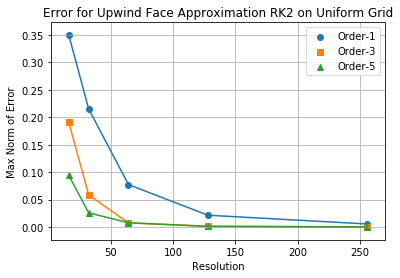

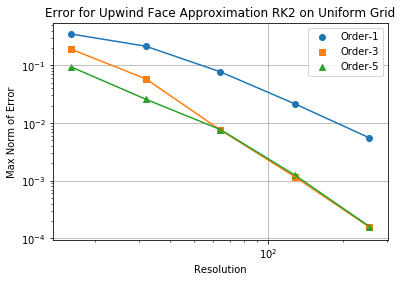

Data Vals:
[0.07724922799913436  0.007572718863927019 0.007694892851771162]
Order: 2

[ 16  32  64 128 256]
iter: 0
nh: 16
t: 0.04419417382415922 29427/665857
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
iter: 1
nh: 32
t: 0.02209708691207961 18463/835540
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
iter: 2
nh: 64
t: 0.011048543456039806 2741/248087
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you nee

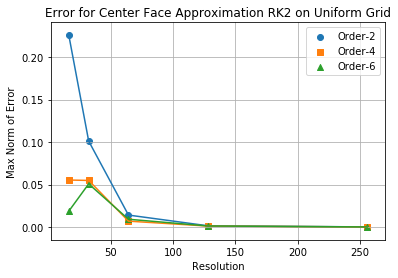

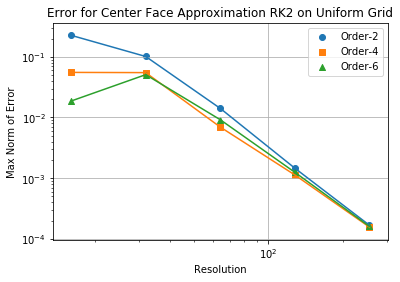

Data Vals:
[0.014093426591978209 0.006943232264738808 0.00916934203554598 ]
['Order-1', '0.07724922799913436', '0.021459044330553567', '0.0055138799100397096']
All done.
['Order-2', '0.014093426591978209', '0.0014573586262752736', '0.00016719728181591176']
All done.
['Order-3', '0.007572718863927019', '0.0011650377750979102', '0.00015567307365160765']
All done.
['Order-4', '0.006943232264738808', '0.0011277182853753898', '0.00015583060243395952']
All done.
['Order-5', '0.007694892851771162', '0.001247528193330405', '0.00015948372559970725']
All done.
['Order-6', '0.00916934203554598', '0.0012461909302263763', '0.00015971710824613794']
All done.


In [9]:
orders = 3
refLin = [[] for o in range(orders)]
dataVals = np.zeros(orders, float)

goThru = 1
rks = 1
if (All):
    goThru = 2
    deriv = 'UD'
    rks = 3
    

errorTot = [[] for i in range(2 * orders)]
slope1 = np.zeros(2 * orders, float)
slope2 = np.zeros(2 * orders, float)
    
for q in range(goThru):
    if ((deriv == 'U') or (deriv == 'UD')):
        faceApprox = 'Upwind'
    else:
        if ((deriv == 'C') or (deriv == 'CD')):
            faceApprox = 'Center'
        else:
            sys.exit('Invalid entry for deriv!')
    saveName = eqs + deriv + 'RK' + str(RK)
    saveStringLog = savePath + saveName + grid + 'log'
    saveStringLin = savePath + saveName + grid + 'line'
    fig1, ax1 = plt.subplots()
    plt.title('Error for ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
    plt.ylabel('Max Norm of Error')
    plt.xlabel('Resolution')
    plt.grid(True)
    fig2, ax2 = plt.subplots()
    plt.title('Error for ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
    plt.ylabel('Max Norm of Error')
    plt.xlabel('Resolution')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    for o in range(orders):
        order = 2*o + 1
        if ((deriv == 'CD') or (deriv == 'C')):
            order = order + 1
        print('Order:', order)
        print('')


        nhVec, errorTot[order - 1] = WaveEqConvergenceTest(omega0, physics, CFL, RK, order, diff, func, args, dataPts, AMR, numRefCel = 4, plot = plot)
        if (o == 0):
            marker = 'o'
            linestyle = '--'
        else:
            if (o == 1):
                marker = 's'
                linestyle = '-.'
            else:
                marker = '^'
                linestyle = ':'

        dataVals[o] = errorTot[order - 1][2]
        slope2[order - 1] = np.log(errorTot[order - 1][-2] / errorTot[order - 1][-1]) / np.log(nhVec[-2] / nhVec[-1])
        slope1[order - 1] = np.log(errorTot[order - 1][-3] / errorTot[order - 1][-2]) / np.log(nhVec[-3] / nhVec[-2])
        slopeAve = (slope1[order - 1] + slope2[order - 1]) / 2
        refLin[o] = nhVec.astype(float)**(-order)
        factorOff = dataVals[o] / refLin[o][2]
        refLin[o] = factorOff * refLin[o]
    #     ax1.plot(nhVec, refLin[o], color = PT.ColorDefault(o), zorder = 0, linestyle = linestyle)
    #     ax2.plot(nhVec, refLin[o], color = PT.ColorDefault(o), zorder = 0, linestyle = linestyle)

        ax1.plot(nhVec, errorTot[order - 1])
        ax1.scatter(nhVec, errorTot[order - 1], marker = marker, label = 'Order-' + str(order))
        ax2.plot(nhVec, errorTot[order - 1])
        ax2.scatter(nhVec, errorTot[order - 1], marker = marker, label = 'Order-' + str(order))



        with open(savePath + eqs+ 'RK' + str(RK) + 'Order' + str(order) + grid + meds + 'LogInfo.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)

            # write the header
            writer.writerow(nhVec)
            writer.writerow(errorTot[order - 1])
            writer.writerow(['', '', '', slope1[order - 1], slope2[order - 1]])

    # ax2.yscale('log')

    ax1.legend()
    ax2.legend()
    fig1.savefig(saveStringLin + '.png', bbox_inches = 'tight', dpi = 300, transparent = False)
    fig2.savefig(saveStringLog + '.png', bbox_inches = 'tight', dpi = 300, transparent = False)
    plt.show()
    plt.show()
    print('Data Vals:')
    print(dataVals)
    deriv = 'CD'

if (All):
    with open(savePath + eqs + 'RK' + str(RK) + grid + meds + 'Master.csv', 'w', encoding='UTF8', newline='') as g:
        writer = csv.writer(g)

        for order in range(2 * orders):
            # write the header
            mastString = [str(i) for i in errorTot[order][1:]]
            

            mastString[0] = 'Order-' + str(order + 1)
            writer.writerow(mastString)
            print(mastString)
            print('All done.')
            writer.writerow(['', '', slope1[order], slope2[order]])

# fig, ax = plt.subplots()
# plt.plot(nhVec, errorTot)
# plt.title('Error for Order-' + str(order) + ' ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
# plt.ylabel('Max Norm of Error')
# plt.xlabel('Resolution')
# plt.grid(True)
# plt.yscale('log')
# plt.savefig(saveStringLog + '.png', bbox_inches = 'tight', dpi = 300, transparent = True)
# plt.show()


In [10]:
refDataVals = np.asarray([refLin[0][2], refLin[1][2], refLin[2][2]])
factorOff = dataVals / refDataVals
print(factorOff)

print('')

[1. 1. 1.]



In [11]:
# def ConvergTest1(omega, deriv, order):
#     # Write in error trap for wavenumber and nh_max.
#     nh_max = omega.nh_max
#     iters = int(np.log(nh_max) / np.log(2))
#     wave = WT.MakeWaves(omega)
#     testWave = 2 * np.pi * wave[:, 2]
#     waves = wave[:, 1]
#     DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
#     CoarseOp = GTT.MakeFullWeight(nh_max)
#     exactDerivOp = TT.ExactSpatOp(omega) # , 0, waves, -1, order)
#     exactDeriv = waves @ exactDerivOp
#     nhs = 2 ** (np.arange(iters) + 1)
#     print(iters)
#     NormVec = []#[[] for i in range()]
#     for i in range(iters):
#         print(i)
#         nh = int(nh_max / (2 ** i))
#         DerivOp = 0.5 * DerivOp[:nh, :nh]
#         DerivOp[0, nh - 1] = DerivOp[1, 0]
#         DerivOp[nh - 1, 0] = DerivOp[0, 1]
#         if (i > 0):
#             CoarseOp = CoarseOp[:nh, :int(2 * nh)]
#             waves = CoarseOp @ waves
#             testWave = CoarseOp @ testWave
#             exactDeriv = CoarseOp @ exactDeriv
#         testDeriv = DerivOp @ waves#[:, :nh]
#         errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
#         NormVec.append(TT.VectorNorm(errorVec))
#         print('test and exact:')
#         print(testDeriv)
#         print(exactDeriv)
#         print(testWave)
#         print(errorVec)
#         print(errorVec ** 2)
#         print(sum(errorVec ** 2))
#         print(np.sqrt(sum(errorVec ** 2)))
#         print('')
#         print(NormVec[i])
#     NormVec = np.asarray(NormVec)[::-1].transpose()
#     print('NormVec is')
#     print(NormVec)
#     return nhs, NormVec

In [12]:
# def ConvergTest(omega, deriv, order):
#     # Write in error trap for wavenumber and nh_max.
#     nh_max = omega.nh_max
#     iters = int(np.log(nh_max) / np.log(2))
#     waves = WT.MakeWaves(omega)
# #     testWave = 2 * np.pi * wave[:, 2]
# #     waves = wave[:, 1]
#     DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
#     CoarseOp = GTT.MakeFullWeight(nh_max)
#     exactDerivOp = TT.ExactSpatOp(omega) #, 0, waves, -1, order)
#     exactDeriv = waves @ exactDerivOp
#     nhs = 2 ** (np.arange(iters) + 1)
#     print(iters)
#     NormVecs = np.zeros((iters, nh_max), float)#[[] for i in range()]
#     mask = np.zeros(nh_max, int)
#     masks = []
#     for i in range(iters):
#         print(i)
#         nh = int(nh_max / (2 ** i))
        
#         mask[:nh] = 1
#         masks.append(list(mask))
#         # mask = list(mask)
#         print('mask:')
#         print(mask)
#         print(masks)
#         DerivOp = 0.5 * DerivOp[:nh, :nh]
#         DerivOp[0, nh - 1] = DerivOp[1, 0]
#         DerivOp[nh - 1, 0] = DerivOp[0, 1]
#         if (i > 0):
#             CoarseOp = CoarseOp[:nh, :int(2 * nh)]
#             waves = CoarseOp @ waves
# #             testWave = CoarseOp @ testWave
#             exactDeriv = CoarseOp @ exactDeriv
#         testDeriv = DerivOp @ waves#[:, :nh]
#         errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
#         NormVec = TT.VectorNorm(errorVec)
        
#         #NormVec = ma.masked_array(NormVec, mask = mask)
        
#         NormVecs[i, :] = NormVec
#         print('Before Mask:')
#         print(NormVecs[i, :])
        
#         print('After Mask:')
#         print(NormVecs[i, :])
#         #print(NormVecs[::-1])
#         print('test and exact:')
#         print(testDeriv)
#         print(exactDeriv)
# #         print(testWave)
#         print(errorVec)
#         print(errorVec ** 2)
#         print(sum(errorVec ** 2, axis = 0))
#         print(np.sqrt(sum(errorVec ** 2, axis = 0)))
#         print('')
#         print(NormVecs[i])
#     masks = [item for sublist in masks for item in sublist]
#     print(masks)
#     print(NormVecs)
#     NormVecs = np.asarray(NormVecs)[::-1]#.transpose()
#     ma.masked_array(NormVecs, mask = list(masks))
#     print('NormVecs is')
#     print(NormVecs)
#     return nhs, NormVecs

In [13]:
# nhs1, NormVec1 = ConvergTest1(omega, deriv, order)
# print(nhs1)


In [14]:
# nhs, NormVec = ConvergTest(omega, deriv, order)
# print(nhs)


In [15]:
# plt.figure()
# plt.plot(nhs1, NormVec1)
# print(NormVec1)
# print('')
# plt.show()

In [16]:
# plt.figure()
# plt.plot(nhs, NormVec[:, 1])
# print(NormVec[:, 1])
# print('')
# plt.yscale('log')
# plt.show()

In [17]:
# print('32:', [0.16092122, 0.45034975, 1.22071342, 2.90704182, 0.90031632])
# print('512:', [2.52326242e-03, 7.13656831e-03, 2.01819198e-02, 5.70452747e-02, 1.60921219e-01, 4.50349746e-01, 1.22071342e+00, 2.90704182e+00, 9.00316316e-01])

In [18]:
# A = np.arange(16).reshape(4, 4)
# print(A)
# print(A ** 2)
# print('')
# print(sum(A, axis = 0))
# out = TT.VectorNorm(A)
# print(out)
# print(A[:, :2])
# A = ma.masked_array(A, mask=[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
# print(A)
# print(type([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]))
# C = np.ones(6, float)
# print(type(C))
# C = list(C)
# print(type(C))

In [19]:
nh=32
halfO=4
nt=1


[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
t: 0.02209708691207961
func is <function AdvectRHS at 0x7f852beed8c8>
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
You are using AdvectRHS()!
In SolverTools: AdvectRHS(), you need to fix rhsE to work in non-uniform media!
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?


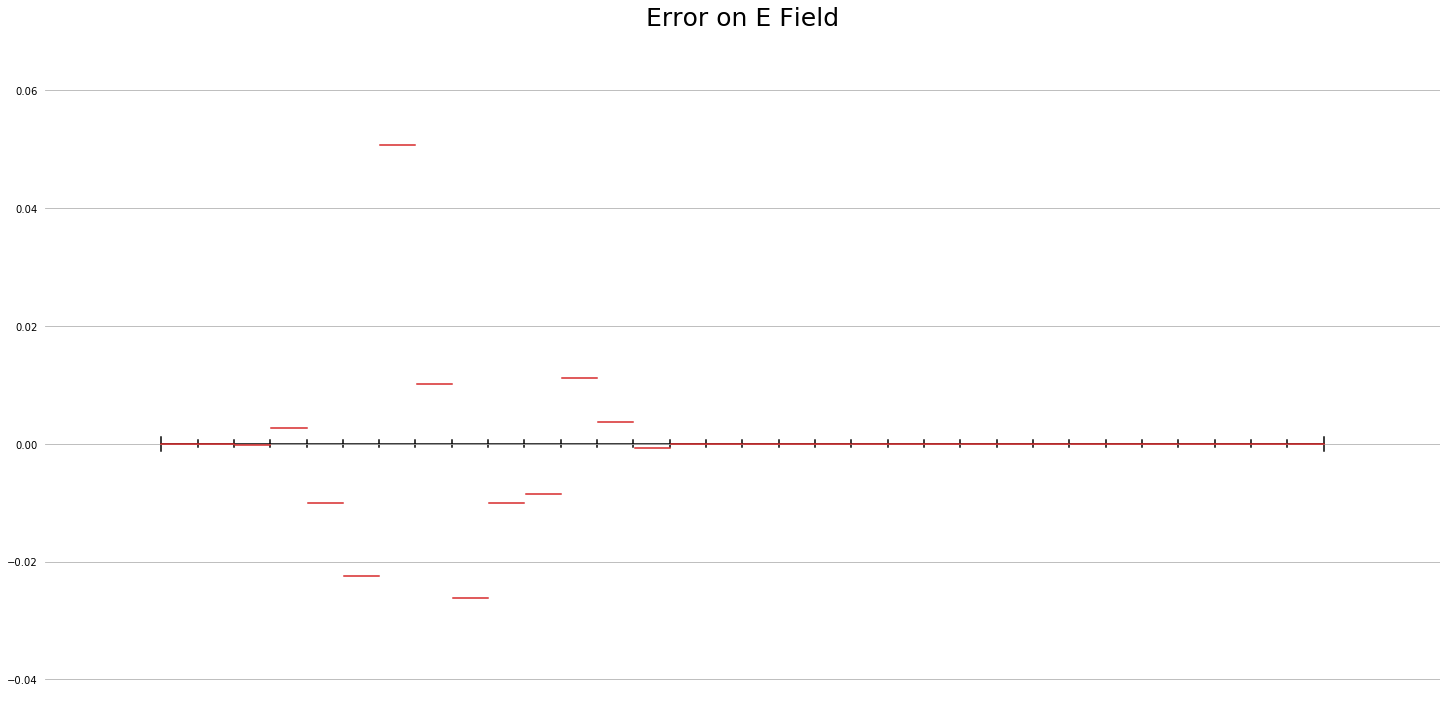

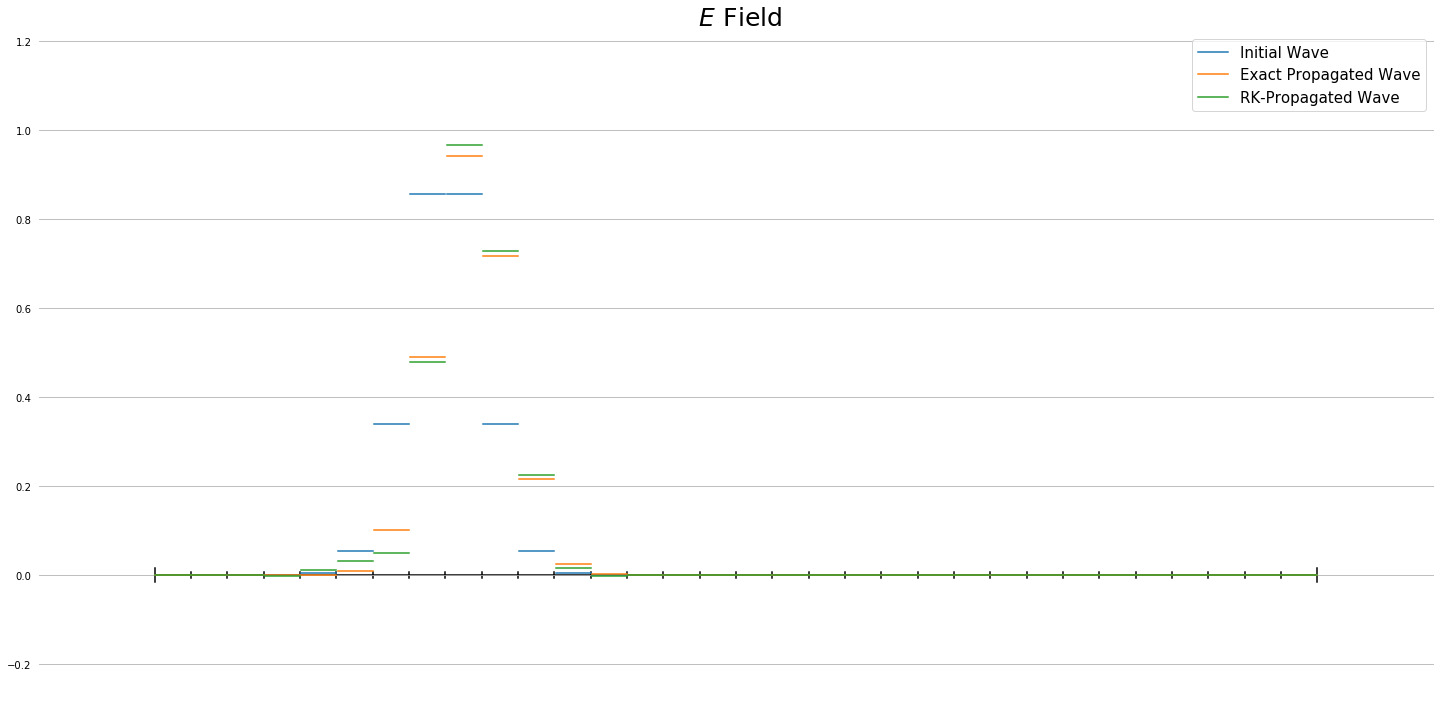

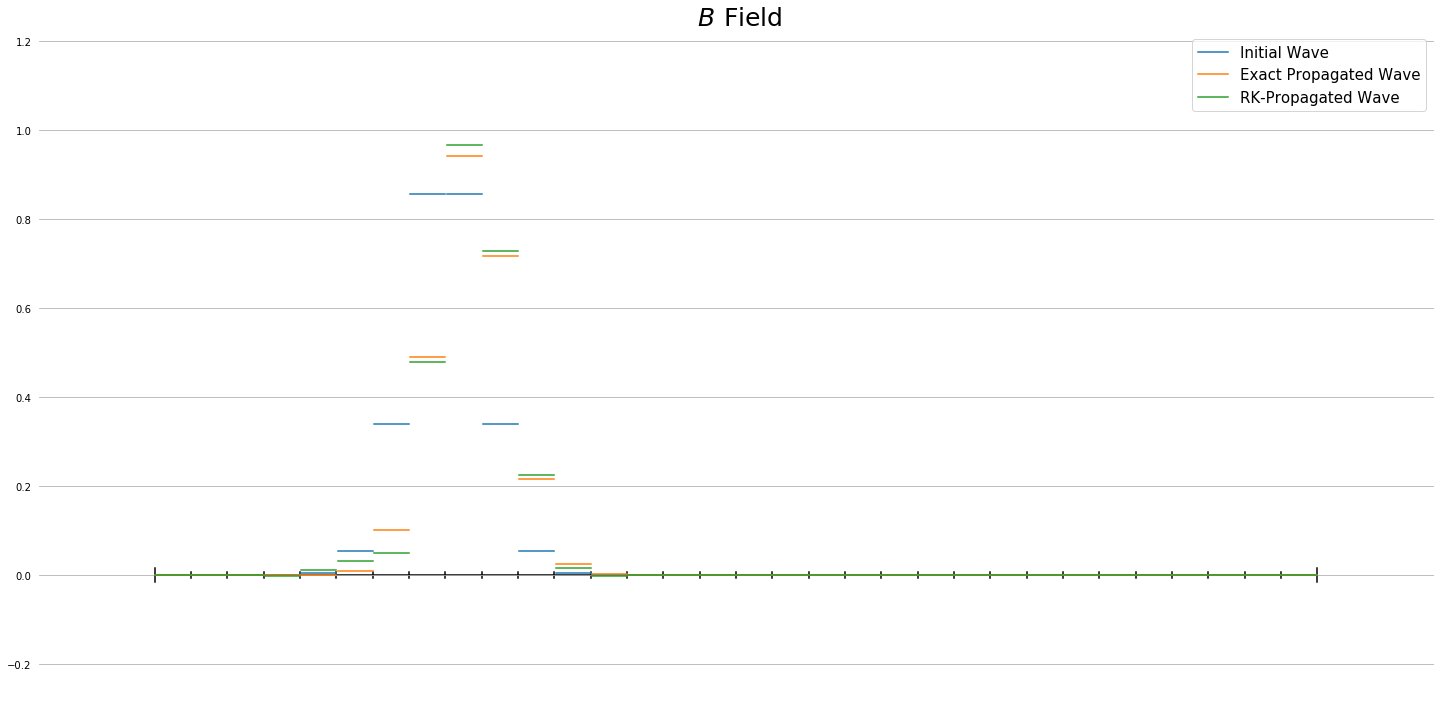

In [20]:



omega = BT.Grid(nh)
finepart = list(int(nh / 2) + np.arange(-int((halfO * nh) / nh_min), int((halfO * nh) / nh_min)))
# omega.AddPatch(refRatio, finepart)
print(finepart)

xCell = omega.xCell
physics = BT.PhysProps(omega, epsilons, mus, locs, L)
degFreed = omega.degFreed
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
#         waves = waves @ nullspace
wavesMat = OT.Block(waves, var = 2)
nullspaceBlock = OT.Block(nullspace, var = 2)

c = physics.cVec
cMat = physics.cMat
c1 = c[0]

t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt, override = True)


waveInit = WFT.InitCond(omega, physics, func, args)
FCoefs = FFTT.FourierCoefs(waves @ nullspace, waveInit)
print('t:', t)

wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

# Find propagated coeficients on coarse and fine grid.
FCoefsProp = FFTT.FourierCoefs(waves @ nullspace, wavePropEx)

solverCoefs = ST.RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, ST.WaveEqRHS, override = True)
wavePropSolv = wavesMat @ nullspaceBlock @ solverCoefs

errorVec = wavePropEx - wavePropSolv
                
errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = nullspace @ errorCoefs[:degFreed], rescale = 5, yGrid = True, plotCont = False, title = 'Error on E Field')

allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
allCoefs = nullspaceBlock @ allCoefs

labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']


errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels, plotCont = False)


In [ ]:
omega = BT.Grid(nh)
finepart = list(int(nh / 2) + np.arange(-int((halfO * nh) / nh_min), int((halfO * nh) / nh_min)))
omega.AddPatch(refRatio, finepart)
print(finepart)

xCell = omega.xCell
physics = BT.PhysProps(omega, epsilons, mus, locs, L)
degFreed = omega.degFreed
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
#         waves = waves @ nullspace
wavesMat = OT.Block(waves, var = 2)
nullspaceBlock = OT.Block(nullspace, var = 2)

c = physics.cVec
cMat = physics.cMat
c1 = c[0]

t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt, override = True)


waveInit = WFT.InitCond(omega, physics, func, args)
FCoefs = FFTT.FourierCoefs(waves @ nullspace, waveInit)
print('t:', t)

wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

# Find propagated coeficients on coarse and fine grid.
FCoefsProp = FFTT.FourierCoefs(waves @ nullspace, wavePropEx)

solverCoefs = ST.RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, ST.WaveEqRHS, override = True)
wavePropSolv = wavesMat @ nullspaceBlock @ solverCoefs

errorVec = wavePropEx - wavePropSolv

errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = nullspace @ errorCoefs[:degFreed], rescale = 5, yGrid = True, plotCont = False, title = 'Error on E Field')


allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
allCoefs = nullspaceBlock @ allCoefs

labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']


errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels, plotCont = False)


In [ ]:

nh = nh*2

omega = BT.Grid(nh)
finepart = list(int(nh / 2) + np.arange(-int((halfO * nh) / nh_min), int((halfO * nh) / nh_min)))
# omega.AddPatch(refRatio, finepart)
print(finepart)

xCell = omega.xCell
physics = BT.PhysProps(omega, epsilons, mus, locs, L)
degFreed = omega.degFreed
waves = WT.MakeWaves(omega)
nullspace = OT.FindNullspace(omega, waves)
#         waves = waves @ nullspace
wavesMat = OT.Block(waves, var = 2)
nullspaceBlock = OT.Block(nullspace, var = 2)

c = physics.cVec
cMat = physics.cMat
c1 = c[0]

t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt, override = True)


waveInit = WFT.InitCond(omega, physics, func, args)
FCoefs = FFTT.FourierCoefs(waves @ nullspace, waveInit)
print('t:', t)

wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

# Find propagated coeficients on coarse and fine grid.
FCoefsProp = FFTT.FourierCoefs(waves @ nullspace, wavePropEx)

solverCoefs = ST.RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, ST.WaveEqRHS, override = True)
wavePropSolv = wavesMat @ nullspaceBlock @ solverCoefs

errorVec = wavePropEx - wavePropSolv
                
errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = nullspace @ errorCoefs[:degFreed], rescale = 5, yGrid = True, plotCont = False, title = 'Error on E Field')

allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
allCoefs = nullspaceBlock @ allCoefs

labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']


errorCoefs = PT.Load(FFTT.FourierCoefs(waves @ nullspace, errorVec))

PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels, plotCont = False)


In [ ]:
A = np.arange(64).reshape(8, 8)
print(A)
print(A[1:, 2:-2])
print('')

In [ ]:
x = np.arange(5)
print(x)
print(x[2:])
xString = [str(i) for i in x[1:]]
xString[0] = 'a'
print(xString)
print('')

In [ ]:
with open(savePath + 'Test.csv', 'w', encoding='UTF8', newline='') as g:
    writer = csv.writer(g)
    
    for order in range(2 * orders):
        # write the header
        mastString = [str(i) for i in errorTot[order][1:]]
        print(mastString)

        mastString[0] = 'Order-' + str(order)
        writer.writerow(mastString)
        writer.writerow(['', '', slope1[order], slope2[order]])